In [1]:
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:4096

In [2]:
!pip install plotly

In [3]:
import numpy as np
import os

from captum.attr import IntegratedGradients

import torch
from torch import nn 
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from custom_dataset import CustomDataset
from network import Network
from utils import *
import torch.nn.functional as F

In [4]:
torch.cuda.device_count()

1

In [5]:

parent_directory = '/data/users2/pnadigapusuresh1/JobOutputs'
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = Network()
model.fc1 = nn.Sequential(nn.Linear(512,2))
model = nn.DataParallel(model)
model.to(device)

# Loading the model from Job 5436878
#loading model from 6066159
#load_path = os.path.join(parent_directory,'6066159','models','epoch_170')

#loading model from 1780660
load_path = os.path.join(parent_directory,'1818979','models_fold','1','epoch_37')
model.load_state_dict(torch.load(load_path))

Using cuda device


<All keys matched successfully>

In [7]:
#%%
########################
# Loading the Data #####
########################

torch.manual_seed(52)
np.random.seed(52)
# number of subprocesses to use for data loading
num_workers = 1
# how many samples per batch to load
batch_size = 1

In [8]:

all_data = CustomDataset(train=True,valid=False)


valid_data = CustomDataset(train= False,valid=False)

# get filtered variables
vars = valid_data.vars.iloc[valid_data.test_idx]

all_data_sampler = SubsetRandomSampler(range(3500))
valid_sampler = SubsetRandomSampler(valid_data.test_idx)

all_loader = DataLoader(all_data,batch_size=1,sampler=all_data_sampler)
valid_loader = DataLoader(valid_data,batch_size=batch_size, 
                            sampler= valid_sampler, num_workers=num_workers)


In [6]:
X_all = np.zeros((121,145,121))

In [7]:
for X,y in valid_loader:
    X_all = np.add(X_all , X.squeeze())
X_all /= len(valid_loader)
X_all = np.expand_dims(np.expand_dims(X_all,axis =0),axis=0)
X_all = torch.tensor(X_all).float().to(device)

In [8]:
vars

,sex,score,new_score,pos
eid,,,,
3379236,1.0,9.0,1,548
4257749,0.0,4.0,0,1048
3688036,1.0,9.0,1,2740
1014922,0.0,9.0,1,1976
5282939,1.0,9.0,1,4180
...,...,...,...,...
3459340,0.0,2.0,0,954
3915907,1.0,5.0,0,130
3109597,0.0,5.0,0,3134


In [9]:
vars[vars.new_score == 0]

,sex,score,new_score,pos
eid,,,,
4257749,0.0,4.0,0,1048
3575229,0.0,5.0,0,5063
1862711,1.0,4.0,0,2139
3328352,0.0,5.0,0,3432
2384098,0.0,5.0,0,4701
...,...,...,...,...
4513618,0.0,5.0,0,2650
3459340,0.0,2.0,0,954
3915907,1.0,5.0,0,130


In [10]:
len(valid_loader) - 360

187

In [11]:
model.eval()

DataParallel(
  (module): Network(
    (cv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn4): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (cv5): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (bn5): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Sequential(
      (0): Linear(in_features=512, out_features=2, bias=Tr

In [12]:
ig = IntegratedGradients(model)

In [29]:
attr_EG_0 = attr_EG_1 = np.zeros((1,1,121,145,121),dtype = np.float64)
attr_0 = attr_1 = np.zeros((1,1,121,145,121),dtype = np.float64)

In [ ]:
num_0 = num_1 =  0
actual_test = torch.tensor([]).to(device)
deltas = torch.tensor([]).to(device)
pred_test = torch.tensor([]).to(device)
for X,y in valid_loader:
    X,y = X.to(device),y.to(device)
    actual_test = torch.cat((actual_test,y),0)
    X.requires_grad_()
    pred = torch.squeeze(model(torch.unsqueeze(X,1).float()))
    soft_max = F.softmax(pred,dim=0)
    pred_test = torch.cat((pred_test,soft_max.argmax().unsqueeze(0)),0)
    if soft_max.argmax() == y:
        attr, delta = ig.attribute(torch.unsqueeze(X,1).float(), baselines=X_all,target=y, return_convergence_delta=True, 
                        internal_batch_size=5,n_steps=550)
        deltas = torch.cat((deltas,delta.unsqueeze(0).float()),0)
        attr = attr.detach().cpu().numpy().astype(dtype=np.float64)

        if y == 0:
            num_0 += 1
            attr_0 += attr
        else:
            num_1 += 1
            attr_1 += attr

In [30]:
num_0 = num_1 =  0
actual_test = torch.tensor([]).to(device)
deltas = torch.tensor([]).to(device)
pred_test = torch.tensor([]).to(device)
for X,y in valid_loader:
    X,y = X.to(device),y.to(device)
    actual_test = torch.cat((actual_test,y),0)
    X.requires_grad_()
    pred = torch.squeeze(model(torch.unsqueeze(X,1).float()))
    soft_max = F.softmax(pred,dim=0)
    pred_test = torch.cat((pred_test,soft_max.argmax().unsqueeze(0)),0)
    if soft_max.argmax() == y:
        attr_eg = torch.zeros((1,1,121,145,121),dtype=torch.float64).to(device)
        for _ in range(10): 
            baseline,_ = next(iter(all_loader))
            baseline = baseline.unsqueeze(0).to(device).float() 
            attr, delta = ig.attribute(torch.unsqueeze(X,1).float(),baselines=baseline,target=y, return_convergence_delta=True, 
                        internal_batch_size=5,n_steps=100)
            attr_eg = torch.add(attr_eg,attr)
        attr_eg /= 10
        deltas = torch.cat((deltas,delta.unsqueeze(0).float()),0)
        attr_eg = attr_eg.detach().cpu().numpy().astype(dtype=np.float64)

        if y == 0:
            num_0 += 1
            attr_EG_0 += attr_eg
        else:
            num_1 += 1
            attr_EG_1 += attr_eg
    

with open('attr_eg_0.npy', 'wb') as f:
    np.save(f, attr_EG_0)
with open('attr_eg_1.npy', 'wb') as f:
    np.save(f, attr_EG_1)

In [38]:
deltas

tensor([[ 9.6427e-03],
        [-2.2363e-03],
        [ 1.3202e-03],
        [ 2.9284e-03],
        [-1.2109e-03],
        [ 3.2952e-03],
        [ 1.0815e-03],
        [ 2.8910e-03],
        [-2.6585e-03],
        [ 1.1477e-04],
        [-2.1271e-03],
        [-8.2896e-04],
        [ 3.5905e-04],
        [ 8.5041e-04],
        [ 3.4338e-05],
        [ 7.3435e-04],
        [ 1.5449e-04],
        [ 9.6128e-05],
        [ 6.2424e-04]], device='cuda:0')

In [34]:
deltas.squeeze(0)

tensor([[-0.0209],
        [-0.0055],
        [ 0.0123],
        [ 0.0015],
        [ 0.0031],
        [ 0.0081],
        [ 0.0111],
        [-0.0047],
        [ 0.0058],
        [ 0.0049],
        [ 0.0009],
        [ 0.0021],
        [-0.0011],
        [-0.0020],
        [-0.0051],
        [-0.0028],
        [ 0.0039],
        [-0.0009],
        [ 0.0020]], device='cuda:0')

In [18]:
torch.sum(actual_test == pred_test)

tensor(471, device='cuda:0')

In [19]:
print(num_1,num_0)

155 316


In [20]:
((155/187) + (316/360))/2

0.8533273915626857

In [45]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(actual_test.detach().cpu().numpy(),pred_test.detach().cpu().numpy())

0.8533273915626857

In [73]:
attr.mean()

0.554804789350082

In [16]:
attr_1 = np.load('attr_eg_1.npy')
attr_0 = np.load('attr_eg_0.npy')

In [17]:
attr_1.shape

(1, 1, 121, 145, 121)

In [18]:
attr_1 = attr_1/num_1
attr_0 = attr_0/num_0

In [19]:
a1 = np.squeeze(attr_1)
a0 = np.squeeze(attr_0)

In [20]:
mask_a1 = np.abs(a1) > 1e-4
mask_a0 = np.abs(a0) > 1e-4

In [47]:
mask_a1.shape

(121, 145, 121)

In [21]:
import json
with open('region_labels.json','r') as f:
    l = json.load(f)

In [22]:
labels = {v:{'attr_sum':0,'attrs':[]} for k,v in l.items()}

In [23]:
from nilearn.image import load_img 
imf = load_img('/trdapps/linux-x86_64/matlab/toolboxes/spm12/tpm/labels_Neuromorphometrics.nii').get_fdata()

In [22]:
str(int(imf[27,102,68]))

'142'

In [25]:
X = X.squeeze()

In [26]:
X.shape

torch.Size([121, 145, 121])

In [27]:
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            if mask_a1[i,j,k]:
                #print(i,j,k)
                r = imf[i,j,k]
                try:
                    labels[l[str(int(r))]]['attr_sum'] += a1[i,j,k]
                    labels[l[str(int(r))]]['attrs'].append(a1[i,j,k])
                except KeyError:
                    pass

In [59]:
min(labels['Right Cerebellum Exterior']['attrs']),max(labels['Right Cerebellum Exterior']['attrs'])

(-0.053678106483179555, 0.07735504915388842)

### Top regions for Expected Gradients

In [28]:
[(v[0],v[1]['attr_sum']) for v in sorted(labels.items(),key=lambda x: x[1]['attr_sum'],reverse=True)]

[('Right Cerebral White Matter', 0.2704432700460987),
 ('Right Cerebellum Exterior', 0.11454028990415566),
 ('Left Cerebral White Matter', 0.07008051504361126),
 ('Left Cerebellum Exterior', 0.0567995547506754),
 ('Right ITG inferior temporal gyrus', 0.05044168182566143),
 ('Right Putamen', 0.046406568879526044),
 ('Right PCgG posterior cingulate gyrus', 0.03743071441345107),
 ('Left Thalamus Proper', 0.028674928382997112),
 ('Right PIns posterior insula', 0.02788169098036205),
 ('Right Hippocampus', 0.026211590389503558),
 ('Right PCu precuneus', 0.024513919019761587),
 ('Right LiG lingual gyrus', 0.024004355899466433),
 ('Right STG superior temporal gyrus', 0.02298694355286489),
 ('Right TTG transverse temporal gyrus', 0.019259896931165865),
 ('Right IOG inferior occipital gyrus', 0.01844053639374598),
 ('Right MFG middle frontal gyrus', 0.015744219062432),
 ('Right FuG fusiform gyrus', 0.014478448345961655),
 ('Right MTG middle temporal gyrus', 0.013962771251515857),
 ('Brain Stem',

## Top regions for mean baseline

In [59]:
[(v[0],v[1]['attr_sum']) for v in sorted(labels.items(),key=lambda x: x[1]['attr_sum'],reverse=True)]

[('Right Cerebellum Exterior', 0.2679454825991531),
 ('Right ITG inferior temporal gyrus', 0.20210443150585813),
 ('Left Cerebellum Exterior', 0.088814391753454),
 ('Right AnG angular gyrus', 0.06792320863706364),
 ('Right Hippocampus', 0.06617944879348851),
 ('Right Cerebral White Matter', 0.05979821293438215),
 ('Left Cerebral White Matter', 0.05548316651846977),
 ('Right STG superior temporal gyrus', 0.046893822698892786),
 ('Right PCu precuneus', 0.04644708142787141),
 ('Right SMG supramarginal gyrus', 0.045460295180080657),
 ('Right PIns posterior insula', 0.04421936648745881),
 ('Right MTG middle temporal gyrus', 0.04057423974282199),
 ('Right Ventral DC', 0.03977095090584807),
 ('Right MOrG medial orbital gyrus', 0.03915120505876638),
 ('Left ACgG anterior cingulate gyrus', 0.037549996959073385),
 ('Right TTG transverse temporal gyrus', 0.0359028325622458),
 ('Right Putamen', 0.03489053790063075),
 ('Right LiG lingual gyrus', 0.03049140351772865),
 ('Right AIns anterior insula',

In [60]:
labels_0 = {v:{'attr_sum':0,'attrs':[]} for k,v in l.items()}

In [62]:
mask_0 = np.abs(a0) > 1e-5

In [63]:
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            if mask_0[i,j,k]:
                #print(i,j,k)
                r = imf[i,j,k]
                try:
                    labels_0[l[str(int(r))]]['attr_sum'] += a0[i,j,k]
                    labels_0[l[str(int(r))]]['attrs'].append(a0[i,j,k])
                except KeyError:
                    print(r,(i,j,k))

0.0 (4, 48, 53)
0.0 (4, 54, 42)
0.0 (5, 52, 29)
0.0 (5, 54, 45)
0.0 (5, 69, 59)
0.0 (6, 44, 36)
0.0 (6, 44, 57)
0.0 (6, 46, 31)
0.0 (6, 50, 40)
0.0 (6, 52, 30)
0.0 (6, 54, 35)
0.0 (6, 73, 47)
0.0 (7, 47, 43)
0.0 (7, 50, 36)
0.0 (7, 50, 37)
0.0 (7, 52, 34)
0.0 (7, 52, 36)
0.0 (7, 56, 45)
0.0 (7, 61, 37)
0.0 (7, 65, 53)
0.0 (7, 67, 37)
0.0 (7, 67, 43)
0.0 (7, 71, 47)
0.0 (7, 75, 29)
0.0 (7, 84, 57)
0.0 (8, 40, 41)
0.0 (8, 42, 57)
0.0 (8, 43, 47)
0.0 (8, 44, 33)
0.0 (8, 44, 34)
0.0 (8, 44, 57)
0.0 (8, 46, 27)
0.0 (8, 46, 59)
0.0 (8, 46, 61)
0.0 (8, 48, 47)
0.0 (8, 48, 48)
0.0 (8, 48, 69)
0.0 (8, 50, 40)
0.0 (8, 50, 42)
0.0 (8, 51, 36)
0.0 (8, 52, 40)
0.0 (8, 52, 44)
0.0 (8, 53, 46)
0.0 (8, 54, 34)
0.0 (8, 54, 44)
0.0 (8, 54, 55)
0.0 (8, 54, 57)
0.0 (8, 54, 63)
0.0 (8, 56, 67)
0.0 (8, 78, 49)
0.0 (8, 84, 64)
0.0 (9, 42, 56)
0.0 (9, 44, 39)
0.0 (9, 46, 38)
0.0 (9, 46, 40)
0.0 (9, 46, 50)
0.0 (9, 46, 55)
0.0 (9, 47, 62)
0.0 (9, 48, 38)
0.0 (9, 48, 41)
0.0 (9, 48, 46)
0.0 (9, 48, 60)
0.0 (9, 

In [64]:
[(v[0],v[1]['attr_sum']) for v in sorted(labels_0.items(),key=lambda x: x[1]['attr_sum'],reverse=True)]

[('Right Cerebellum Exterior', 0.13126139624234262),
 ('Right ITG inferior temporal gyrus', 0.09918389878541858),
 ('Left Cerebellum Exterior', 0.04356725461220443),
 ('Right AnG angular gyrus', 0.03328437703863312),
 ('Right Hippocampus', 0.03244027808198655),
 ('Right Cerebral White Matter', 0.029385079071973564),
 ('Left Cerebral White Matter', 0.026619365402057123),
 ('Right STG superior temporal gyrus', 0.022977307941696775),
 ('Right PCu precuneus', 0.022777718929275183),
 ('Right SMG supramarginal gyrus', 0.022319674348471718),
 ('Right PIns posterior insula', 0.021700945093935123),
 ('Right MTG middle temporal gyrus', 0.019823773023460584),
 ('Right Ventral DC', 0.01947773603225351),
 ('Right MOrG medial orbital gyrus', 0.01917422359177601),
 ('Left ACgG anterior cingulate gyrus', 0.018403477742584343),
 ('Right TTG transverse temporal gyrus', 0.017610760435735378),
 ('Right Putamen', 0.017096681515017368),
 ('Right LiG lingual gyrus', 0.014919140167482536),
 ('Right AIns anter

## Top regions from black image baseline


In [60]:
[(v[0],v[1]['attr_sum']) for v in sorted(labels.items(),key=lambda x: x[1]['attr_sum'],reverse=True)]

[('Right Cerebellum Exterior', 1.2198976284022571),
 ('Left Cerebellum Exterior', 1.005752743684415),
 ('Right ITG inferior temporal gyrus', 0.4010783211521832),
 ('Left MCgG middle cingulate gyrus', 0.3519987680268254),
 ('Right Amygdala', 0.3487582652372523),
 ('Right Putamen', 0.3310668289363118),
 ('Right Ent entorhinal area', 0.2019250095123366),
 ('Left LiG lingual gyrus', 0.19498428218407582),
 ('Left Cerebral White Matter', 0.1896889934409438),
 ('Right Calc calcarine cortex', 0.18220975275910883),
 ('Left Calc calcarine cortex', 0.15574371797394557),
 ('Right MOrG medial orbital gyrus', 0.12098528225521578),
 ('Brain Stem', 0.11899420211832404),
 ('Right MTG middle temporal gyrus', 0.1178689307162349),
 ('Left MOrG medial orbital gyrus', 0.10262874411452631),
 ('Left PHG parahippocampal gyrus', 0.09460104286518795),
 ('Right STG superior temporal gyrus', 0.08297713546323475),
 ('Right SMG supramarginal gyrus', 0.08167827589519142),
 ('Right SOG superior occipital gyrus', 0.075

In [61]:
labels_0 = {v:{'attr_sum':0,'attrs':[]} for k,v in l.items()}

In [63]:
mask_0 = np.abs(a0) > 1e-4

In [64]:
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            if mask_0[i,j,k]:
                #print(i,j,k)
                r = imf[i,j,k]
                try:
                    labels_0[l[str(int(r))]]['attr_sum'] += a0[i,j,k]
                    labels_0[l[str(int(r))]]['attrs'].append(a0[i,j,k])
                except KeyError:
                    pass

In [65]:
[(v[0],v[1]['attr_sum']) for v in sorted(labels_0.items(),key=lambda x: x[1]['attr_sum'],reverse=True)]

[('Right Cerebellum Exterior', 0.5993606194179991),
 ('Left Cerebellum Exterior', 0.4950160123016042),
 ('Right ITG inferior temporal gyrus', 0.19694458189202138),
 ('Left MCgG middle cingulate gyrus', 0.1741540026078996),
 ('Right Amygdala', 0.17109631202724981),
 ('Right Putamen', 0.16283327498599),
 ('Right Ent entorhinal area', 0.0993933634650417),
 ('Left Cerebral White Matter', 0.09626092287156951),
 ('Left LiG lingual gyrus', 0.09610316796145281),
 ('Right Calc calcarine cortex', 0.09004396085451631),
 ('Left Calc calcarine cortex', 0.07546752731964666),
 ('Brain Stem', 0.06264991563565295),
 ('Right MOrG medial orbital gyrus', 0.06088513595576329),
 ('Right MTG middle temporal gyrus', 0.05607949651278175),
 ('Left MOrG medial orbital gyrus', 0.05002061956995757),
 ('Left PHG parahippocampal gyrus', 0.04622841533034773),
 ('Right STG superior temporal gyrus', 0.0409879354339168),
 ('Right SMG supramarginal gyrus', 0.040131948119758155),
 ('Left TMP temporal pole', 0.037106337590

## Regions using expected gradients

In [106]:
label_val['Right Ventral DC']

'61'

In [107]:
r_ventral_dc = imf == 61

In [108]:
r_ventral_dc.astype(int)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [79]:
affine = np.array([[  -1.5,    0. ,    0. ,   90. ],
       [   0. ,    1.5,    0. , -126. ],
       [   0. ,    0. ,    1.5,  -72. ],
       [   0. ,    0. ,    0. ,    1. ]])

In [80]:
import nibabel as nib

In [109]:
array_img = nib.Nifti1Image(r_ventral_dc.astype(int), affine)

/tmp/ipykernel_5132/3742323984.py:1: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  array_img = nib.Nifti1Image(r_ventral_dc.astype(int), affine)


In [110]:
nib.save(array_img,'r_ventral_dc.nii')

In [ ]:
vars.new_score.value_counts()

Text(0, 0.5, 'Number of subjects')

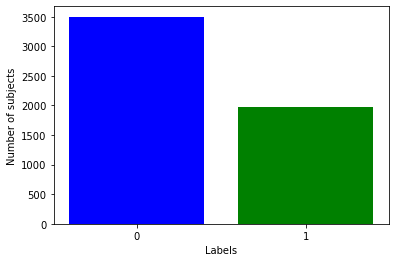

In [1]:
from matplotlib import pyplot as plt 

plt.bar(['0','1'],[3501,1968],color=['blue','green'])
plt.xlabel('Labels')
plt.ylabel('Number of subjects')
#plt.title('Bar plot showing the distribution of lower and higher group ends')


### testing the region difference of 'Left MCgG middle cingulate gyrus'


In [75]:
label_val = {v:k for k,v in l.items()}

In [86]:
label_val['Right Cerebral White Matter']

'44'

In [47]:
mean_GM_0 = []
mean_GM_1 = []
for X,y in valid_loader:
    X,y = X.to(device),y.to(device)
    X.requires_grad_()
    pred = torch.squeeze(model(torch.unsqueeze(X,1).float()))
    soft_max = F.softmax(pred)
    if soft_max.argmax() == y:
        X = X.detach().cpu().numpy().squeeze()
        # applying mask
        X = np.ma.array(X,mask = imf != 139,fill_value= 0).filled()
        if y == 0:
            mean_GM_0.append(np.mean(X))
        else:
            mean_GM_1.append(np.mean(X))

/tmp/ipykernel_961369/2694020616.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max = F.softmax(pred)


In [52]:
print(np.mean(mean_GM_0),np.mean(mean_GM_1))

0.0004325015641832032 0.0004650561719839211


In [111]:
len(l)

136